# Clustering Newsgroups data using K-means
* We'll use the Newsgroup dataset from scikit learn.
* We will use all data from four categories, 'alt.atheism', 'talk.religion.misc', 'comp.graphics', and 'sci.space', as an example.

# Step 1: Loading and Preprocessing the data
* We'll load the data and clean it up a bit with the preprocessing techniques we saw in the previous chapter (remove numbers, lemmatize the words, remove names)

In [1]:
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer

# Defining our categories (the ones we'll use to fetch the data)
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space'
]

groups = fetch_20newsgroups(subset = 'all', categories=categories)

# Getting our labels and label names
labels = groups.target
label_names = groups.target_names

def is_letter_only(word):
    for char in word:
        if not char.isalpha():
            return False
        return True

# Removing names and lemmatizing 
all_names = set(names.words())
lemmatizer = WordNetLemmatizer()

# An empty list to store our cleaned data
data_cleaned = []

for doc in groups.data:
    doc = doc.lower()
    doc_cleaned = " ".join(lemmatizer.lemmatize(word) for word in doc.split() if word.isalpha() and word not in all_names)
    data_cleaned.append(doc_cleaned)
    

In [2]:
# Converting the cleaned text data into count vectors
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer(stop_words="english", max_features = None, 
                              max_df = 0.5, min_df = 2)
data = count_vector.fit_transform(data_cleaned)


Note that we don't limit the max_features, but we set up max_df and min_df, which mean maximum and minimum document frequency. Document frequency of a word is measured by the fraction of documents (samples) in the dataset that contain this word. 

# Step 2: Clustering the data
* We'll try clustering the data (cleaned) as is, however, we need to know that as of this moment, the tokens in data (the CountVector) is only considering term_frequency, which might give us incorrect results

In [3]:
from sklearn.cluster import KMeans

# Defining 4 clusters (we have indeed four categories)
k = 4
kmeans = KMeans(n_clusters=k, random_state = 42, n_init = 'auto')
kmeans.fit(data)


KMeans(n_clusters=4, n_init='auto', random_state=42)

In [4]:
# Checking the sizes of the resulting clusters. 
from collections import Counter

# We're supposed to have 4 clusters, which our KMeans algorithm should have identified
clusters = kmeans.labels_
print(Counter(clusters))


Counter({3: 3360, 0: 17, 1: 7, 2: 3})


* As suspected, our results are incorrect.  It turns out that our count-based features are not sufficiently representative. A better numerical representation for text data is the term frequency-inverse document frequency (tf-idf). Instead of simply using the token count, or the so-called term frequency (tf), it assigns each term frequency a weighting factor that is inversely proportional to the document frequency. 
$idf(t, D) = log\frac{n_D}{1 + n_t}$
* $n_D$ = Total number of documents.
* $n_t$ is the number of documents containing the term t.
* We add a 1 to avoid division by zero

In [5]:
# Using TFidfVectorizer instead of CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector = TfidfVectorizer(stop_words = 'english', max_features = None,
                              max_df=0.5, min_df = 2)

# Fitting our model
vectorized_data = tfidf_vector.fit_transform(data_cleaned)
kmeans.fit(vectorized_data)

clusters = kmeans.labels_
print(Counter(clusters))

Counter({1: 1478, 2: 797, 0: 601, 3: 511})


* This time we got a much more balanced set of clusters

In [6]:
import numpy as np
# Visualizing the clusters and the top 10 tf-idf terms representing each cluster
# Create a dictionary called cluster_label. 
# The keys are cluster numbers, and the values are the labels of the data points that belong to that cluster.
cluster_label = {i: labels[np.where(clusters == i)] for i in range(k)}

# Get the names of the features (words) from the tf-idf vectorizer
terms = tfidf_vector.get_feature_names_out()

# Get the coordinates of the cluster centers from the trained KMeans model
centroids = kmeans.cluster_centers_

# Loop through each cluster and its corresponding list of label indices
for cluster, index_list in cluster_label.items():
    # Create a counter for the labels in this cluster
    counter = Counter(cluster_label[cluster])
    
    # Print the number of samples in this cluster
    print(f"cluster_{cluster}: {len(index_list)} samples")
    
    # For each label index and its count in this cluster, sorted by count in descending order
    for label_index, count in sorted(counter.items(), key=lambda x: x[1], reverse = True):
        # Print the label name and its count
        print(f"{label_names[label_index]}: {count} samples ")
    
    # Print the top 10 terms in this cluster, based on their tf-idf values
    print("Top 10 terms: ")
    for ind in centroids[cluster].argsort()[-10:]:
        print(" %s" % terms[ind], end="")
    print()

cluster_0: 601 samples
sci.space: 598 samples 
alt.atheism: 1 samples 
talk.religion.misc: 1 samples 
comp.graphics: 1 samples 
Top 10 terms: 
 just orbit moon hst nasa mission launch wa shuttle space
cluster_1: 1478 samples
alt.atheism: 522 samples 
talk.religion.misc: 387 samples 
sci.space: 338 samples 
comp.graphics: 231 samples 
Top 10 terms: 
 say people know like think ha just university wa article
cluster_2: 797 samples
comp.graphics: 740 samples 
sci.space: 49 samples 
talk.religion.misc: 5 samples 
alt.atheism: 3 samples 
Top 10 terms: 
 computer need know looking thanks university program file graphic image
cluster_3: 511 samples
alt.atheism: 273 samples 
talk.religion.misc: 235 samples 
sci.space: 2 samples 
comp.graphics: 1 samples 
Top 10 terms: 
 doe bible think believe say people christian jesus wa god


* Some of the insights obtained from clustering our documents like this: 
1. cluster_0 is obviously about space and includes almost all sci.space samples and related terms such as moon, nasa, launch, shuttle, and space
2. cluster_1 is more of a generic topic
3. cluster_2 is more about computer graphics and related terms, such as format, program, file, graphic, and image
4. cluster_3 is an interesting one, which successfully brings together two overlapping topics, atheism and religion, with key terms including moral, morality, jesus, christian, and god

# Step 2: Trying the "Elbow" method to find the optimal k value

k = 1, SSE = 3325.7314297145113
k = 2, SSE = 3305.8353672863814
k = 3, SSE = 3291.4371181290608
k = 4, SSE = 3279.4973721653237
k = 5, SSE = 3268.7375478859517
k = 6, SSE = 3262.104449429238
k = 7, SSE = 3251.831874254017
k = 8, SSE = 3246.6358570767507
k = 9, SSE = 3237.7766440936107
k = 10, SSE = 3231.9446334383433
k = 11, SSE = 3224.8774560755055
k = 12, SSE = 3217.822374352688
k = 13, SSE = 3210.7724425068063
k = 14, SSE = 3208.3400046228035
k = 15, SSE = 3203.416629141201
k = 16, SSE = 3191.189228560107
k = 17, SSE = 3187.3453333317957
k = 18, SSE = 3182.187084460528
k = 19, SSE = 3176.7345567615007
k = 20, SSE = 3166.938310344579


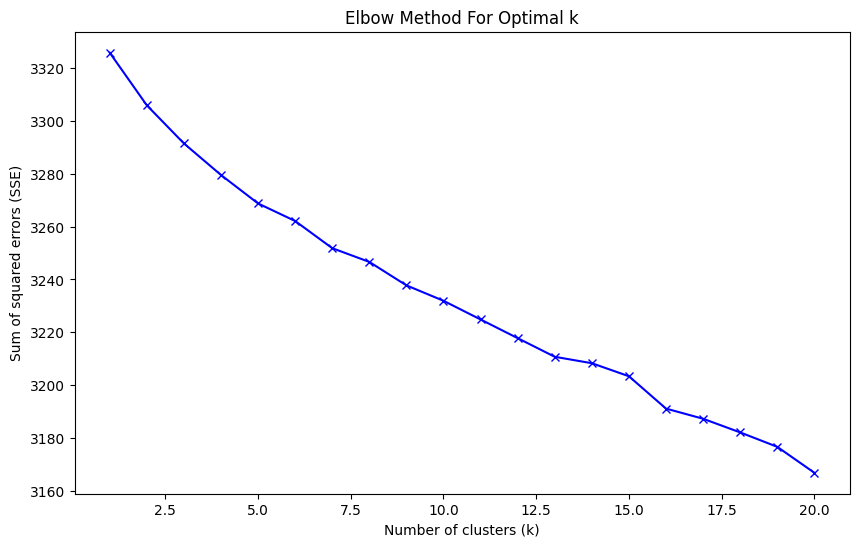

In [10]:
import matplotlib.pyplot as plt
# Defining our list of possible k values from 1 to 20
k_list = list(range(1, 21))
sse_list = [0] * len(k_list)

# Iterate through the list of K values.
for k_index, k in enumerate(k_list):
    # Initialize the KMeans model. n_clusters is the number of clusters to form and the number of centroids to generate.
    k_means = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # Fit the KMeans model to our data
    k_means.fit(vectorized_data)
    
    # Print the SSE for this K value
    print(f"k = {k}, SSE = {k_means.inertia_}")
    
    # Store the SSE for this K value in our list of SSEs
    sse_list[k_index] = k_means.inertia_

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_list, sse_list, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared errors (SSE)')
plt.title('Elbow Method For Optimal k')
plt.show()

Unfortunately, we didn't find the right amount of clusters using the 'elbow' method because there isn't really a defined 'drop' in the SSE. 
